In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# ========== python ==========
import os
from logging import Logger
from pathlib import Path
import gc
# noinspection PyUnresolvedReferences
from typing import List, Dict, Tuple, Optional, Union, Callable, Final, Literal, get_args
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
PROJECT_DIR = Path().resolve().parents[1]
os.chdir(PROJECT_DIR)
SEED: Final = 42

In [2]:
from utils.setup import load_param, easy_logger, get_device
from utils.torch import load_model, torch_fix_seed
from torch.utils.tensorboard.writer import SummaryWriter
from ignite.handlers import Checkpoint
from run_for_KGC import main_function
logger = easy_logger('log/test.log')

In [3]:
args = load_param('saved_models/kgc/DevilsFoot075/03/param.pkl')
device = get_device(device_name='cpu', logger=logger)
# args.pre_train = True
args.logger = logger
args.device = device
args.batch_size = 1
args.max_len=512
args.tensorboard_dir=None
args.only_load_trainer_evaluator=True
args.pre_train=False
del args.optuna_file, args.device_name, args.pid
del args.study_name, args.n_trials
logger.info(args)

2023-01-01 10:00:28 - INFO - 919838096.py - 13 - Namespace(notebook=False, train_anyway=False, logfile='saved_models/kgc/DevilsFoot075/03/log.log', param_file='saved_models/kgc/DevilsFoot075/03/param.pkl', tensorboard_dir=None, checkpoint_dir='saved_models/kgc/DevilsFoot075/03/checkpoint/', model_path='saved_models/kgc/DevilsFoot075/03/model.pth', model_version='03', resume_from_checkpoint=False, resume_from_last_point=False, only_load_trainer_evaluator=True, resume_checkpoint_path=None, console_level='info', pre_train=False, train_valid_test=False, only_train=True, use_for_challenge100=False, use_for_challenge090=False, use_for_challenge075=True, use_title='DevilsFoot', do_optuna=False, story_special_num=5, relation_special_num=5, entity_special_num=5, padding_token_e=0, cls_token_e=1, mask_token_e=2, sep_token_e=3, bos_token_e=4, padding_token_r=0, cls_token_r=1, mask_token_r=2, sep_token_r=3, bos_token_r=4, padding_token_s=0, cls_token_s=1, mask_token_s=2, sep_token_s=3, bos_token_s

In [4]:
torch_fix_seed(seed=SEED)
model, data_dict = main_function(args, logger=logger)
encoder_last_layer = model.transformer.layers[-1]
model.eval()
dataset_train, dataset_valid, dataset_test = data_dict['datasets']
triple = dataset_train.triple
data_helper = data_dict['data_helper']
evaluator = data_dict['train_items']['evaluator']
load_model(model, args.model_path, device)
print(len(data_helper.processed_train_triple), len(triple))

2023-01-01 10:00:32 - INFO - run_for_KGC.py - 775 - ----- make datahelper start. -----
2023-01-01 10:00:32 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2023-01-01 10:00:32 - INFO - data_helper.py - 208 - entity_length: 7844
2023-01-01 10:00:32 - INFO - data_helper.py - 209 - relation_length: 63
2023-01-01 10:00:32 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2023-01-01 10:00:32 - INFO - data_helper.py - 440 - ==========Show DataHelper==========
2023-01-01 10:00:32 - INFO - data_helper.py - 441 - ==========
2023-01-01 10:00:32 - INFO - data_helper.py - 207 - ==========Show MyRawData==========
2023-01-01 10:00:32 - INFO - data_helper.py - 208 - entity_length: 7844
2023-01-01 10:00:32 - INFO - data_helper.py - 209 - relation_length: 63
2023-01-01 10:00:32 - INFO - data_helper.py - 212 - ==========Show MyRawData==========
2023-01-01 10:00:32 - INFO - data_helper.py - 443 - ==========
2023-01-01 10:00:32 - INFO - data_helper.py - 445 - entity_spec

13572 16676


In [5]:
from run_for_KGC import get_all_tokens
to_token = "{}".format
PAD_E = to_token("pad_e")
CLS_E = to_token('cls_e')
MASK_E: Final[str] = to_token('mask_e')
SEP_E: Final[str] = to_token('sep_e')
BOS_E: Final[str] = to_token('bos_e')
PAD_R: Final[str] = to_token('pad_r')
CLS_R: Final[str] = to_token('cls_r')
MASK_R: Final[str] = to_token('mask_r')
SEP_R: Final[str] = to_token('sep_r')
BOS_R: Final[str] = to_token('bos_r')

((pad_token_e, pad_token_r), (cls_token_e, cls_token_r), (mask_token_e, mask_token_r),
     (sep_token_e, sep_token_r), (bos_token_e, bos_token_r)) = get_all_tokens(args)

data_helper.set_special_names(
    index2name_entity={pad_token_e: PAD_E, cls_token_e: CLS_E, mask_token_e: MASK_E, sep_token_e: SEP_E, bos_token_e: BOS_E},
    index2name_relation={pad_token_r: PAD_R, cls_token_r: CLS_R, mask_token_r: MASK_R, sep_token_r: SEP_R, bos_token_r: BOS_R},
)

In [6]:
entities = data_helper.processed_entities
d_e = {e: i for i, e in enumerate(entities)}
relations = data_helper.processed_relations
d_r = {r: i for i, r in enumerate(relations)}
triple_df = pd.DataFrame([(entities[_t[0]], relations[_t[1]], entities[_t[2]]) for _t in triple], columns=['head', 'relation', 'tail']) 
# story_entities = triple_df
# triple_df

In [7]:
def extract(model, target, inputs):
    feature = None

    def forward_hook(module, inputs, _):
        # 順伝搬の出力を features というグローバル変数に記録する
        global features
        # 1. detach でグラフから切り離す。
        # 2. clone() でテンソルを複製する。モデルのレイヤーで ReLU(inplace=True) のように
        #    inplace で行う層があると、値がその後のレイヤーで書き換えられてまい、
        #    指定した層の出力が取得できない可能性があるため、clone() が必要。
        x, _, _ = inputs
        outputs = module.forward(x, x, x, need_weights=True)[1]
        features = outputs.detach().clone()

    # コールバック関数を登録する。
    handle = target.register_forward_hook(forward_hook)

    # 推論する
    model.eval()
    model(inputs, torch.LongTensor([[]]), torch.LongTensor([[]]), torch.LongTensor([[]]))

    # コールバック関数を解除する。
    handle.remove()

    return features

In [8]:
def heatmap_(index):
    input_ = dataset[index]
    # display([(i, entities[h], relations[r], entities[t]) for i, (h, r, t) in enumerate(input_)])
    features = extract(model, encoder_last_layer.self_attn, dataset[0][None, :])[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_)])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    display(df_atten)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    for i in range(len(df_atten)):
        display(i, df_atten.iloc[i,:3].tolist())
        display(df_atten.sort_values(f'atten_from{i}', ascending=False).iloc[:10,:3])
        print("----------")
    plt.show()
# heatmap_(300)

In [9]:
def make_heatmap2_(input_):
    assert len(input_) == 1
    features = extract(model, encoder_last_layer.self_attn, input_)[0]
    df_atten = pd.DataFrame([[entities[h], relations[r], entities[t]]+[features[j, i].item() for j in range(len(features))] for i, (h, r, t) in enumerate(input_[0])])
    df_atten.columns=['head', 'relation', 'tail',] + [f'atten_from{i}' for i in range(len(df_atten.columns)-3)]
    sns.heatmap(df_atten.iloc[:,3:])
    plt.show()
    return df_atten

In [10]:
story_entities = triple_df['head'].tolist()
# print(story_entities)

In [11]:
def make_ranking(_from, _to, _predicate, _whom, _subject, _why, _what, _where):
    if not (_from is None and _to is None):
        _start_index = story_entities.index(_from)-1 
        _end_index = len(story_entities) - story_entities[::-1].index(_to)
    else: 
        _start_index = 0
        _end_index = 0
    question_ = torch.tensor(
        [
            [d_e['bos_e'],d_r['bos_r'],d_e['bos_e']],
            [d_e['mask_e'],d_r['kgc:infoSource'],d_e['AllTitle:Holmes']],
            [d_e['mask_e'],d_r['kgc:hasPredicate'],d_e[_predicate]],
            [d_e['mask_e'],d_r['kgc:whom'],d_e[_whom]],
            [d_e['mask_e'],d_r['kgc:subject'],d_e[_subject]],
            [d_e['mask_e'],d_r['kgc:why'],d_e[_why]],
            [d_e['mask_e'],d_r['kgc:what'],d_e[_what]],
            [d_e['mask_e'],d_r['kgc:where'],d_e[_where]],
        ]
    )
    mask_ = torch.tensor(
        [
            [False, False, False],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
            [True, False, True],
        ]
    )
    questions = torch.cat([triple[_start_index: _end_index], question_], dim=0).unsqueeze(0)
    masks = torch.cat([torch.zeros(_end_index-_start_index,3), mask_], dim=0).to(torch.bool).transpose(1,0).unsqueeze(0)
    tmp = []
    with torch.no_grad():
        _, (story_pred, relation_pred, entity_pred) = model(questions, masks[:,0], masks[:,1], masks[:,2])
        sorted_ = torch.argsort(entity_pred.to('cpu'), dim=1, descending=True)
        for i in range(sorted_.shape[1]):
            ans_= sorted_[:, i]
            info_source_, predicate_, whom_, subj_, why_, what_, where_ = ans_
            tmp.append([entities[predicate_], entities[whom_], entities[subj_], entities[why_], entities[what_], entities[where_]])
    df_ranking = pd.DataFrame(tmp, columns=['predicate', 'whom', 'subject', 'why', 'what', 'where'])
    df_attension = make_heatmap2_(questions)
    return df_ranking, df_attension

In [12]:
MASK_E = 'mask_e'
KILL = 'word.predicate:kill'
TAKE = 'word.predicate:take'
BRING = 'word.predicate:bring'
DIE = 'word.predicate:die'
HIDE = 'word.predicate:hide'

In [13]:
def main_func01(_title, _victim_name, _killer_name, _last_index, _story_len):
    from_ = f'{_title}:{_last_index-_story_len+1}'
    to_ = f'{_title}:{_last_index}'
    victim = f'{_title}:{_victim_name}'
    killer = f'{_title}:{_killer_name}'
    df_ranking, df_attension = make_ranking(
        from_, to_, KILL, victim, MASK_E, MASK_E, MASK_E, MASK_E)

    print(f"{killer}, ranking", df_ranking.index[df_ranking['subject']==killer].tolist())
    display(df_ranking.iloc[:200,:])
    # display(df_attension_SpeckledBand)
    # ヒートマップの作成
    # sns.heatmap(df_atten.iloc[:,3:].iloc[:32,:32])
    len_ = len(df_attension)
    for i in range(len_-20, len_):
        display(i, df_attension.iloc[i,:3].tolist())
        display(df_attension.sort_values(f'atten_from{i}', ascending=False).iloc[:20,[0,1,2,3+i]])
        print("----------")
    return df_ranking, df_attension

### 悪魔の足跡１
Who killed the victims? (criminal & explanation)
被害者: Brenda
犯人: Mortimer
犯行動機: 財産

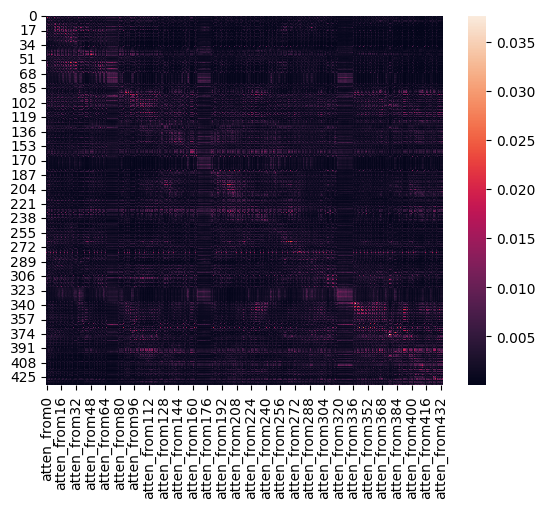

DevilsFoot:Mortimer, ranking [0]


,predicate,whom,subject,why,what,where
0,word.predicate:exist,AllTitle:Watson,DevilsFoot:Mortimer,SpeckledBand:mansion_of_Roylott,AllTitle:Holmes,ResidentPatient:Percy_Trevelyan
1,word.predicate:enter,AllTitle:Holmes,AllTitle:Watson,DevilsFoot:Case_1,DevilsFoot:Roundhay,AllTitle:Holmes
2,word.predicate:open,DevilsFoot:Brenda,DevilsFoot:Brenda,ACaseOfIdentity:Windibank,AllTitle:Watson,DevilsFoot:Roundhay
3,word.predicate:sit,ACaseOfIdentity:Windibank,DevilsFoot:Owen,SpeckledBand:Roylott,ResidentPatient:Blessington,DevilsFoot:living_room
4,word.predicate:say,DevilsFoot:Mortimer,AllTitle:Holmes,word.predicate:exist,CrookedMan:Henry,DevilsFoot:Mortimer
...,...,...,...,...,...,...
195,CrookedMan:meeting_of_the_St._George_union,CrookedMan:1887-07-06T20:45:00,DateTime:1883-04-01T23:00:00,DevilsFoot:Burnt_powder,DancingMen:E,SpeckledBand:sound
196,word.predicate:cannotPassThrough,word.predicate:steal,word.predicate:talk,SpeckledBand:sound,DateTime:1881-04-01T00:00:00,word.predicate:white
197,word.predicate:raise,word.predicate:restless,DateTime:1883-04-01T10:00:00,ResidentPatient:Pistol,word.predicate:collect,word.predicate:steal
198,CrookedMan:living_room,ACaseOfIdentity:father_of_Sutherland,AbbeyGrange:dining_room,word.predicate:handOver,word.predicate:asleep,word.predicate:dead


415

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from415
268,DevilsFoot:335,kgc:on,DevilsFoot:Smoke_protection_of_lamp,0.017882
278,DevilsFoot:338,kgc:on,DevilsFoot:lamp,0.017259
188,DevilsFoot:320,kgc:hasPredicate,word.predicate:exist,0.005591
34,bos_e,bos_r,bos_e,0.004916
79,bos_e,bos_r,bos_e,0.004849
336,bos_e,bos_r,bos_e,0.004650
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.004649
85,bos_e,bos_r,bos_e,0.004541
64,bos_e,bos_r,bos_e,0.004461
360,bos_e,bos_r,bos_e,0.004435


----------


416

['DevilsFoot:364a', 'kgc:subject', 'DevilsFoot:Mortimer']

,head,relation,tail,atten_from416
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.017198
341,DevilsFoot:350,kgc:subject,DevilsFoot:Mortimer,0.013960
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.012918
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.012794
368,DevilsFoot:356,kgc:infoSource,DevilsFoot:Mortimer,0.011548
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.011484
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.011457
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.011454
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.011162
89,DevilsFoot:302b,kgc:subject,DevilsFoot:Case_2,0.010672


----------


417

['DevilsFoot:364a', 'kgc:hasProperty', 'word.predicate:Criminal']

,head,relation,tail,atten_from417
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.011684
346,DevilsFoot:351,kgc:hasProperty,word.predicate:Victim_of_Case_2,0.011617
418,DevilsFoot:364a,kgc:infoSource,AllTitle:Holmes,0.011491
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.011020
90,DevilsFoot:302b,kgc:hasProperty,word.predicate:death_of_Mortimer,0.010560
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.010078
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.009398
121,DevilsFoot:308,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.009236
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.008947
391,DevilsFoot:361,kgc:subject,DevilsFoot:George,0.008944


----------


418

['DevilsFoot:364a', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from418
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.012197
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.011868
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.011794
366,DevilsFoot:356,kgc:hasPredicate,word.predicate:move,0.011050
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.010454
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.010344
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.010313
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.009937
362,DevilsFoot:355,kgc:hasPredicate,word.predicate:say,0.009903
401,DevilsFoot:362,kgc:infoSource,AllTitle:Holmes,0.009654


----------


419

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from419
268,DevilsFoot:335,kgc:on,DevilsFoot:Smoke_protection_of_lamp,0.018540
278,DevilsFoot:338,kgc:on,DevilsFoot:lamp,0.017118
188,DevilsFoot:320,kgc:hasPredicate,word.predicate:exist,0.005811
34,bos_e,bos_r,bos_e,0.004786
79,bos_e,bos_r,bos_e,0.004687
276,DevilsFoot:338,kgc:hasPredicate,word.predicate:put,0.004575
277,DevilsFoot:338,kgc:what,DevilsFoot:Drug,0.004460
336,bos_e,bos_r,bos_e,0.004429
85,bos_e,bos_r,bos_e,0.004384
64,bos_e,bos_r,bos_e,0.004367


----------


420

['DevilsFoot:365', 'kgc:subject', 'AllTitle:Watson']

,head,relation,tail,atten_from420
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.011084
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.011066
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.010776
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.010746
341,DevilsFoot:350,kgc:subject,DevilsFoot:Mortimer,0.010089
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.008955
380,DevilsFoot:359,kgc:subject,DevilsFoot:Mortimer,0.008879
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.008136
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.008070
349,DevilsFoot:352,kgc:subject,DevilsFoot:Mortimer,0.007881


----------


421

['DevilsFoot:365', 'kgc:hasPredicate', 'word.predicate:say']

,head,relation,tail,atten_from421
90,DevilsFoot:302b,kgc:hasProperty,word.predicate:death_of_Mortimer,0.010710
116,DevilsFoot:307,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.009664
395,DevilsFoot:361,kgc:what,DevilsFoot:table,0.009584
87,DevilsFoot:302a,kgc:hasProperty,word.predicate:death_of_Brenda,0.009190
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.008342
422,DevilsFoot:365,kgc:what,DevilsFoot:366,0.008220
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.007792
418,DevilsFoot:364a,kgc:infoSource,AllTitle:Holmes,0.007363
121,DevilsFoot:308,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.007343
339,DevilsFoot:349,kgc:infoSource,AllTitle:Holmes,0.007229


----------


422

['DevilsFoot:365', 'kgc:what', 'DevilsFoot:366']

,head,relation,tail,atten_from422
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.009420
341,DevilsFoot:350,kgc:subject,DevilsFoot:Mortimer,0.009418
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.009309
116,DevilsFoot:307,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.008336
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.008151
420,DevilsFoot:365,kgc:subject,AllTitle:Watson,0.007468
431,mask_e,kgc:subject,mask_e,0.007415
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.006956
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.006565
115,DevilsFoot:307,kgc:to,DevilsFoot:room,0.006502


----------


423

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from423
278,DevilsFoot:338,kgc:on,DevilsFoot:lamp,0.017534
268,DevilsFoot:335,kgc:on,DevilsFoot:Smoke_protection_of_lamp,0.017532
188,DevilsFoot:320,kgc:hasPredicate,word.predicate:exist,0.005823
34,bos_e,bos_r,bos_e,0.004930
79,bos_e,bos_r,bos_e,0.004820
276,DevilsFoot:338,kgc:hasPredicate,word.predicate:put,0.004617
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.004589
336,bos_e,bos_r,bos_e,0.004584
306,DevilsFoot:345,kgc:from,DevilsFoot:Chair,0.004557
85,bos_e,bos_r,bos_e,0.004549


----------


424

['DevilsFoot:366', 'kgc:subject', 'DevilsFoot:reason_of_death_of_Mortimer']

,head,relation,tail,atten_from424
424,DevilsFoot:366,kgc:subject,DevilsFoot:reason_of_death_of_Mortimer,0.015621
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.014078
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.013973
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.011153
391,DevilsFoot:361,kgc:subject,DevilsFoot:George,0.010816
230,DevilsFoot:328,kgc:subject,DevilsFoot:George,0.010315
426,DevilsFoot:366,kgc:infoSource,DevilsFoot:Watson_s_remarks,0.010109
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.009574
229,DevilsFoot:328,kgc:subject,DevilsFoot:Owen,0.009423
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.009069


----------


425

['DevilsFoot:366', 'kgc:hasProperty', 'word.predicate:suicide']

,head,relation,tail,atten_from425
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.016731
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.014179
230,DevilsFoot:328,kgc:subject,DevilsFoot:George,0.011452
391,DevilsFoot:361,kgc:subject,DevilsFoot:George,0.010981
229,DevilsFoot:328,kgc:subject,DevilsFoot:Owen,0.010575
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.009736
90,DevilsFoot:302b,kgc:hasProperty,word.predicate:death_of_Mortimer,0.009351
346,DevilsFoot:351,kgc:hasProperty,word.predicate:Victim_of_Case_2,0.008525
341,DevilsFoot:350,kgc:subject,DevilsFoot:Mortimer,0.008392
425,DevilsFoot:366,kgc:hasProperty,word.predicate:suicide,0.008295


----------


426

['DevilsFoot:366', 'kgc:infoSource', 'DevilsFoot:Watson_s_remarks']

,head,relation,tail,atten_from426
426,DevilsFoot:366,kgc:infoSource,DevilsFoot:Watson_s_remarks,0.019981
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.016792
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.014789
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.014493
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.014369
224,DevilsFoot:327,kgc:subject,DevilsFoot:Brenda,0.012239
424,DevilsFoot:366,kgc:subject,DevilsFoot:reason_of_death_of_Mortimer,0.010615
365,DevilsFoot:356,kgc:subject,DevilsFoot:something,0.010379
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.009859
230,DevilsFoot:328,kgc:subject,DevilsFoot:George,0.009792


----------


427

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from427
278,DevilsFoot:338,kgc:on,DevilsFoot:lamp,0.017527
268,DevilsFoot:335,kgc:on,DevilsFoot:Smoke_protection_of_lamp,0.016695
188,DevilsFoot:320,kgc:hasPredicate,word.predicate:exist,0.006339
34,bos_e,bos_r,bos_e,0.004887
79,bos_e,bos_r,bos_e,0.004753
276,DevilsFoot:338,kgc:hasPredicate,word.predicate:put,0.004746
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.004543
336,bos_e,bos_r,bos_e,0.004531
277,DevilsFoot:338,kgc:what,DevilsFoot:Drug,0.004515
85,bos_e,bos_r,bos_e,0.004485


----------


428

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from428
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.015048
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.012620
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.012365
401,DevilsFoot:362,kgc:infoSource,AllTitle:Holmes,0.012338
380,DevilsFoot:359,kgc:subject,DevilsFoot:Mortimer,0.011358
426,DevilsFoot:366,kgc:infoSource,DevilsFoot:Watson_s_remarks,0.010724
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.010472
406,DevilsFoot:363,kgc:infoSource,AllTitle:Holmes,0.010315
368,DevilsFoot:356,kgc:infoSource,DevilsFoot:Mortimer,0.010083
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.009101


----------


429

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from429
116,DevilsFoot:307,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.012862
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.009924
115,DevilsFoot:307,kgc:to,DevilsFoot:room,0.009771
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.009619
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.009518
410,DevilsFoot:364,kgc:subject,DevilsFoot:360,0.008837
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.008724
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.008474
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.008343
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.008325


----------


430

['mask_e', 'kgc:whom', 'DevilsFoot:Brenda']

,head,relation,tail,atten_from430
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.015856
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.013999
380,DevilsFoot:359,kgc:subject,DevilsFoot:Mortimer,0.013878
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.013843
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.012717
368,DevilsFoot:356,kgc:infoSource,DevilsFoot:Mortimer,0.011432
357,DevilsFoot:354,kgc:subject,DevilsFoot:Mortimer,0.011141
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.011010
374,DevilsFoot:358,kgc:subject,DevilsFoot:Mortimer,0.010815
100,DevilsFoot:304,kgc:infoSource,DevilsFoot:Mortimer,0.010597


----------


431

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from431
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.018886
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.018503
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.016784
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.016398
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.015170
341,DevilsFoot:350,kgc:subject,DevilsFoot:Mortimer,0.014952
380,DevilsFoot:359,kgc:subject,DevilsFoot:Mortimer,0.013571
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.013263
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.012595
368,DevilsFoot:356,kgc:infoSource,DevilsFoot:Mortimer,0.011883


----------


432

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from432
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.010276
377,DevilsFoot:358,kgc:what,AllTitle:Watson,0.009759
116,DevilsFoot:307,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.009278
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.008999
426,DevilsFoot:366,kgc:infoSource,DevilsFoot:Watson_s_remarks,0.008957
406,DevilsFoot:363,kgc:infoSource,AllTitle:Holmes,0.008479
376,DevilsFoot:358,kgc:what,AllTitle:Holmes,0.007888
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.007860
398,DevilsFoot:362,kgc:subject,DevilsFoot:others,0.007798
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.007702


----------


433

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from433
401,DevilsFoot:362,kgc:infoSource,AllTitle:Holmes,0.012866
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.010671
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.010552
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.009961
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.009758
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.009429
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.009083
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.009018
380,DevilsFoot:359,kgc:subject,DevilsFoot:Mortimer,0.008998
377,DevilsFoot:358,kgc:what,AllTitle:Watson,0.008886


----------


434

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from434
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.012527
426,DevilsFoot:366,kgc:infoSource,DevilsFoot:Watson_s_remarks,0.012145
406,DevilsFoot:363,kgc:infoSource,AllTitle:Holmes,0.011490
414,DevilsFoot:364,kgc:infoSource,AllTitle:Holmes,0.011148
401,DevilsFoot:362,kgc:infoSource,AllTitle:Holmes,0.010764
368,DevilsFoot:356,kgc:infoSource,DevilsFoot:Mortimer,0.010697
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.010637
147,DevilsFoot:313,kgc:subject,DevilsFoot:someone,0.010395
206,DevilsFoot:323,kgc:infoSource,AllTitle:Holmes,0.010082
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.009805


----------


In [14]:
title = 'DevilsFoot'
victim_name = 'Brenda'
killer_name = 'Mortimer'
last_index = 366
story_len = 80

df_ranking_SpeckledBand, df_attension_SpeckledBand = main_func01(title, victim_name, killer_name, last_index, story_len)

In [16]:
pd.set_option('display.max_rows', 500)

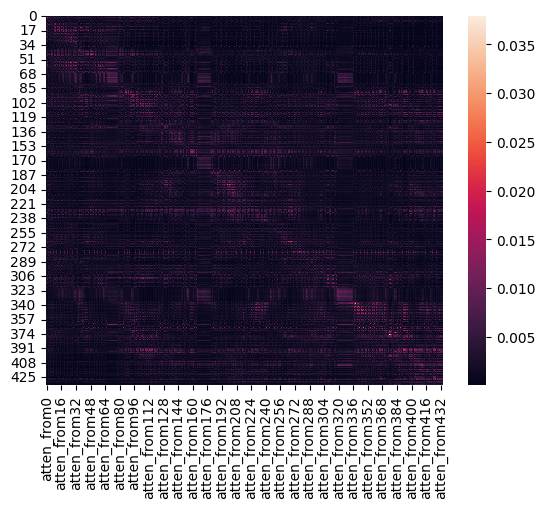

DevilsFoot:Sterndale, ranking [135]


,predicate,whom,subject,why,what,where
0,word.predicate:exist,AllTitle:Holmes,DevilsFoot:Mortimer,DevilsFoot:Case_1,AllTitle:Holmes,ResidentPatient:Percy_Trevelyan
1,word.predicate:enter,AllTitle:Watson,AllTitle:Watson,SpeckledBand:mansion_of_Roylott,DevilsFoot:Roundhay,AllTitle:Holmes
2,word.predicate:open,DevilsFoot:Mortimer,DevilsFoot:Owen,ACaseOfIdentity:Windibank,AllTitle:Watson,DevilsFoot:Roundhay
3,word.predicate:sit,ACaseOfIdentity:Windibank,DevilsFoot:Brenda,SpeckledBand:Roylott,ResidentPatient:Blessington,DevilsFoot:living_room
4,word.predicate:arrive,DevilsFoot:Roundhay,DevilsFoot:George,ResidentPatient:Percy_Trevelyan,CrookedMan:Henry,DevilsFoot:Mortimer
5,bos_e,ResidentPatient:Percy_Trevelyan,ResidentPatient:Percy_Trevelyan,word.predicate:arrive,DevilsFoot:Owen,ResidentPatient:Blessington
6,word.predicate:have,ResidentPatient:Blessington,DevilsFoot:Roundhay,DevilsFoot:Roundhay,word.predicate:notExist,AllTitle:Watson
7,word.predicate:happen,DevilsFoot:Brenda,AllTitle:Holmes,DevilsFoot:Mortimer,ResidentPatient:Percy_Trevelyan,CrookedMan:Henry
8,word.predicate:say,SpeckledBand:Roylott,ACaseOfIdentity:Windibank,word.predicate:exist,AbbeyGrange:Criminal,AbbeyGrange:Sir_Eustace_Brackenstall
9,word.predicate:cut,SpeckledBand:VentilationHole,word.predicate:examine,CrookedMan:beast,CrookedMan:beast,AbbeyGrange:Criminal


415

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from415
268,DevilsFoot:335,kgc:on,DevilsFoot:Smoke_protection_of_lamp,0.017726
278,DevilsFoot:338,kgc:on,DevilsFoot:lamp,0.017176
188,DevilsFoot:320,kgc:hasPredicate,word.predicate:exist,0.005525
34,bos_e,bos_r,bos_e,0.004916
79,bos_e,bos_r,bos_e,0.004851
336,bos_e,bos_r,bos_e,0.004655
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.004646
85,bos_e,bos_r,bos_e,0.004543
64,bos_e,bos_r,bos_e,0.004465
360,bos_e,bos_r,bos_e,0.004443


----------


416

['DevilsFoot:364a', 'kgc:subject', 'DevilsFoot:Mortimer']

,head,relation,tail,atten_from416
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.016586
341,DevilsFoot:350,kgc:subject,DevilsFoot:Mortimer,0.013600
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.012471
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.012469
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.011454
368,DevilsFoot:356,kgc:infoSource,DevilsFoot:Mortimer,0.011299
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.011204
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.011060
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.010994
89,DevilsFoot:302b,kgc:subject,DevilsFoot:Case_2,0.010466


----------


417

['DevilsFoot:364a', 'kgc:hasProperty', 'word.predicate:Criminal']

,head,relation,tail,atten_from417
346,DevilsFoot:351,kgc:hasProperty,word.predicate:Victim_of_Case_2,0.011763
418,DevilsFoot:364a,kgc:infoSource,AllTitle:Holmes,0.011543
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.011207
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.011064
90,DevilsFoot:302b,kgc:hasProperty,word.predicate:death_of_Mortimer,0.010559
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.009720
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.009137
121,DevilsFoot:308,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.009046
391,DevilsFoot:361,kgc:subject,DevilsFoot:George,0.008819
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.008776


----------


418

['DevilsFoot:364a', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from418
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.011851
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.011790
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.011440
366,DevilsFoot:356,kgc:hasPredicate,word.predicate:move,0.010836
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.010211
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.010107
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.010044
362,DevilsFoot:355,kgc:hasPredicate,word.predicate:say,0.010017
401,DevilsFoot:362,kgc:infoSource,AllTitle:Holmes,0.009595
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.009377


----------


419

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from419
268,DevilsFoot:335,kgc:on,DevilsFoot:Smoke_protection_of_lamp,0.018379
278,DevilsFoot:338,kgc:on,DevilsFoot:lamp,0.017040
188,DevilsFoot:320,kgc:hasPredicate,word.predicate:exist,0.005726
34,bos_e,bos_r,bos_e,0.004789
79,bos_e,bos_r,bos_e,0.004692
276,DevilsFoot:338,kgc:hasPredicate,word.predicate:put,0.004533
277,DevilsFoot:338,kgc:what,DevilsFoot:Drug,0.004454
336,bos_e,bos_r,bos_e,0.004438
85,bos_e,bos_r,bos_e,0.004388
64,bos_e,bos_r,bos_e,0.004374


----------


420

['DevilsFoot:365', 'kgc:subject', 'AllTitle:Watson']

,head,relation,tail,atten_from420
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.010915
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.010731
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.010489
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.010168
341,DevilsFoot:350,kgc:subject,DevilsFoot:Mortimer,0.010053
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.008781
380,DevilsFoot:359,kgc:subject,DevilsFoot:Mortimer,0.008637
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.008097
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.007879
349,DevilsFoot:352,kgc:subject,DevilsFoot:Mortimer,0.007855


----------


421

['DevilsFoot:365', 'kgc:hasPredicate', 'word.predicate:say']

,head,relation,tail,atten_from421
90,DevilsFoot:302b,kgc:hasProperty,word.predicate:death_of_Mortimer,0.010613
395,DevilsFoot:361,kgc:what,DevilsFoot:table,0.009761
116,DevilsFoot:307,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.009433
87,DevilsFoot:302a,kgc:hasProperty,word.predicate:death_of_Brenda,0.009154
422,DevilsFoot:365,kgc:what,DevilsFoot:366,0.008552
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.008285
418,DevilsFoot:364a,kgc:infoSource,AllTitle:Holmes,0.007529
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.007514
121,DevilsFoot:308,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.007251
115,DevilsFoot:307,kgc:to,DevilsFoot:room,0.007156


----------


422

['DevilsFoot:365', 'kgc:what', 'DevilsFoot:366']

,head,relation,tail,atten_from422
341,DevilsFoot:350,kgc:subject,DevilsFoot:Mortimer,0.009318
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.009243
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.008983
116,DevilsFoot:307,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.007986
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.007880
430,mask_e,kgc:whom,DevilsFoot:Mortimer,0.007640
420,DevilsFoot:365,kgc:subject,AllTitle:Watson,0.007492
431,mask_e,kgc:subject,mask_e,0.007031
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.006761
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.006488


----------


423

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from423
278,DevilsFoot:338,kgc:on,DevilsFoot:lamp,0.017438
268,DevilsFoot:335,kgc:on,DevilsFoot:Smoke_protection_of_lamp,0.017360
188,DevilsFoot:320,kgc:hasPredicate,word.predicate:exist,0.005735
34,bos_e,bos_r,bos_e,0.004928
79,bos_e,bos_r,bos_e,0.004823
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.004600
336,bos_e,bos_r,bos_e,0.004591
276,DevilsFoot:338,kgc:hasPredicate,word.predicate:put,0.004578
85,bos_e,bos_r,bos_e,0.004551
306,DevilsFoot:345,kgc:from,DevilsFoot:Chair,0.004510


----------


424

['DevilsFoot:366', 'kgc:subject', 'DevilsFoot:reason_of_death_of_Mortimer']

,head,relation,tail,atten_from424
424,DevilsFoot:366,kgc:subject,DevilsFoot:reason_of_death_of_Mortimer,0.014479
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.013567
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.013401
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.011046
391,DevilsFoot:361,kgc:subject,DevilsFoot:George,0.010490
426,DevilsFoot:366,kgc:infoSource,DevilsFoot:Watson_s_remarks,0.010231
230,DevilsFoot:328,kgc:subject,DevilsFoot:George,0.009891
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.009812
425,DevilsFoot:366,kgc:hasProperty,word.predicate:suicide,0.009203
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.009078


----------


425

['DevilsFoot:366', 'kgc:hasProperty', 'word.predicate:suicide']

,head,relation,tail,atten_from425
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.016695
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.013946
230,DevilsFoot:328,kgc:subject,DevilsFoot:George,0.011335
391,DevilsFoot:361,kgc:subject,DevilsFoot:George,0.010874
229,DevilsFoot:328,kgc:subject,DevilsFoot:Owen,0.010358
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.009530
90,DevilsFoot:302b,kgc:hasProperty,word.predicate:death_of_Mortimer,0.009367
425,DevilsFoot:366,kgc:hasProperty,word.predicate:suicide,0.008702
346,DevilsFoot:351,kgc:hasProperty,word.predicate:Victim_of_Case_2,0.008606
341,DevilsFoot:350,kgc:subject,DevilsFoot:Mortimer,0.008171


----------


426

['DevilsFoot:366', 'kgc:infoSource', 'DevilsFoot:Watson_s_remarks']

,head,relation,tail,atten_from426
426,DevilsFoot:366,kgc:infoSource,DevilsFoot:Watson_s_remarks,0.020673
392,DevilsFoot:361,kgc:subject,DevilsFoot:Brenda,0.016294
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.014464
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.014396
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.014224
224,DevilsFoot:327,kgc:subject,DevilsFoot:Brenda,0.011551
365,DevilsFoot:356,kgc:subject,DevilsFoot:something,0.010540
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.009830
424,DevilsFoot:366,kgc:subject,DevilsFoot:reason_of_death_of_Mortimer,0.009537
230,DevilsFoot:328,kgc:subject,DevilsFoot:George,0.009371


----------


427

['bos_e', 'bos_r', 'bos_e']

,head,relation,tail,atten_from427
278,DevilsFoot:338,kgc:on,DevilsFoot:lamp,0.017456
268,DevilsFoot:335,kgc:on,DevilsFoot:Smoke_protection_of_lamp,0.016508
188,DevilsFoot:320,kgc:hasPredicate,word.predicate:exist,0.006224
34,bos_e,bos_r,bos_e,0.004890
79,bos_e,bos_r,bos_e,0.004756
276,DevilsFoot:338,kgc:hasPredicate,word.predicate:put,0.004691
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.004571
336,bos_e,bos_r,bos_e,0.004544
277,DevilsFoot:338,kgc:what,DevilsFoot:Drug,0.004510
85,bos_e,bos_r,bos_e,0.004488


----------


428

['mask_e', 'kgc:infoSource', 'AllTitle:Holmes']

,head,relation,tail,atten_from428
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.015087
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.012509
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.011952
401,DevilsFoot:362,kgc:infoSource,AllTitle:Holmes,0.011919
426,DevilsFoot:366,kgc:infoSource,DevilsFoot:Watson_s_remarks,0.011544
380,DevilsFoot:359,kgc:subject,DevilsFoot:Mortimer,0.010997
406,DevilsFoot:363,kgc:infoSource,AllTitle:Holmes,0.010411
368,DevilsFoot:356,kgc:infoSource,DevilsFoot:Mortimer,0.010145
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.009879
418,DevilsFoot:364a,kgc:infoSource,AllTitle:Holmes,0.009480


----------


429

['mask_e', 'kgc:hasPredicate', 'word.predicate:kill']

,head,relation,tail,atten_from429
116,DevilsFoot:307,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.012052
411,DevilsFoot:364,kgc:subject,DevilsFoot:363,0.010059
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.009414
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.008941
410,DevilsFoot:364,kgc:subject,DevilsFoot:360,0.008921
115,DevilsFoot:307,kgc:to,DevilsFoot:room,0.008878
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.008642
430,mask_e,kgc:whom,DevilsFoot:Mortimer,0.008439
377,DevilsFoot:358,kgc:what,AllTitle:Watson,0.008325
121,DevilsFoot:308,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.008287


----------


430

['mask_e', 'kgc:whom', 'DevilsFoot:Mortimer']

,head,relation,tail,atten_from430
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.012394
368,DevilsFoot:356,kgc:infoSource,DevilsFoot:Mortimer,0.012266
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.012246
380,DevilsFoot:359,kgc:subject,DevilsFoot:Mortimer,0.011392
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.011344
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.010650
418,DevilsFoot:364a,kgc:infoSource,AllTitle:Holmes,0.010039
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.009678
401,DevilsFoot:362,kgc:infoSource,AllTitle:Holmes,0.009048
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.009048


----------


431

['mask_e', 'kgc:subject', 'mask_e']

,head,relation,tail,atten_from431
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.019020
361,DevilsFoot:355,kgc:subject,DevilsFoot:Mortimer,0.016325
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.015261
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.014605
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.014576
341,DevilsFoot:350,kgc:subject,DevilsFoot:Mortimer,0.014473
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.013272
380,DevilsFoot:359,kgc:subject,DevilsFoot:Mortimer,0.012823
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.012353
349,DevilsFoot:352,kgc:subject,DevilsFoot:Mortimer,0.012058


----------


432

['mask_e', 'kgc:why', 'mask_e']

,head,relation,tail,atten_from432
377,DevilsFoot:358,kgc:what,AllTitle:Watson,0.010361
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.009967
116,DevilsFoot:307,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.009147
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.008832
426,DevilsFoot:366,kgc:infoSource,DevilsFoot:Watson_s_remarks,0.008611
406,DevilsFoot:363,kgc:infoSource,AllTitle:Holmes,0.008572
376,DevilsFoot:358,kgc:what,AllTitle:Holmes,0.008028
393,DevilsFoot:361,kgc:subject,DevilsFoot:Owen,0.007981
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.007938
401,DevilsFoot:362,kgc:infoSource,AllTitle:Holmes,0.007828


----------


433

['mask_e', 'kgc:what', 'mask_e']

,head,relation,tail,atten_from433
401,DevilsFoot:362,kgc:infoSource,AllTitle:Holmes,0.012819
396,DevilsFoot:361,kgc:infoSource,AllTitle:Holmes,0.010500
92,DevilsFoot:303,kgc:subject,DevilsFoot:Mortimer,0.010169
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.009700
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.009462
370,DevilsFoot:357,kgc:subject,DevilsFoot:Mortimer,0.009428
380,DevilsFoot:359,kgc:subject,DevilsFoot:Mortimer,0.009085
345,DevilsFoot:351,kgc:subject,DevilsFoot:Mortimer,0.009049
416,DevilsFoot:364a,kgc:subject,DevilsFoot:Mortimer,0.008968
377,DevilsFoot:358,kgc:what,AllTitle:Watson,0.008967


----------


434

['mask_e', 'kgc:where', 'mask_e']

,head,relation,tail,atten_from434
426,DevilsFoot:366,kgc:infoSource,DevilsFoot:Watson_s_remarks,0.012222
428,mask_e,kgc:infoSource,AllTitle:Holmes,0.012096
406,DevilsFoot:363,kgc:infoSource,AllTitle:Holmes,0.011369
414,DevilsFoot:364,kgc:infoSource,AllTitle:Holmes,0.011051
368,DevilsFoot:356,kgc:infoSource,DevilsFoot:Mortimer,0.010667
401,DevilsFoot:362,kgc:infoSource,AllTitle:Holmes,0.010530
113,DevilsFoot:307,kgc:subject,DevilsFoot:Porter,0.010395
147,DevilsFoot:313,kgc:subject,DevilsFoot:someone,0.009991
206,DevilsFoot:323,kgc:infoSource,AllTitle:Holmes,0.009843
116,DevilsFoot:307,kgc:infoSource,DevilsFoot:Remark_of_Porter,0.009824


----------


In [17]:
title = 'DevilsFoot'
victim_name = 'Mortimer'
killer_name = 'Sterndale'
last_index = 366
story_len = 80
df_ranking_DevilsFoot2, df_attension_DevilsFoot2 = main_func01(title, victim_name, killer_name, last_index, story_len)